# k-NN on Amazon Reviews Dataset (Part II)


## Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & cleaning.** The review text is now devoid of punctuations, HTML markups and stop words.

## Objective:
**To find accuracy of 10-fold cross validation KNN on vectorized input data, for each of the 4 featurizations, namely BoW, tf-IDF, W2V, tf-IDF weighted W2V. Running time comparison of Brute force vs kd-tree also need to be done.** 

## At a glance:
Random Sampling is done to reduce input data size and time based slicing to split into training and testing data. The accuracy percentage obtained by applying 10-fold cross validation KNN using 4 Featurizations viz. BoW, tf-idf, W2V, tf-idf W2V are compared. The time taken by brute force and kd-tree methods are plotted and analysed. <br><br>

# Preprocessed Data Loading

In [34]:
#loading libraries for knn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

#loading libraries for scikit learn, nlp, db, plot and matrix.
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(3))
print(final.shape)

    index      Id   ProductId          UserId            ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ... 



# Random Sampling & Time Based Slicing

In [35]:
# To randomly sample the data and sort based on time before doing train/ test split.
# The slicing into train & test data will be done later in kfoldcv() function.

num_points = 5000

# you can use random_state for reproducibility
sampled_final = final.sample(n=num_points, random_state=2)

#Sorting data according to Time in ascending order
sorted_final = sampled_final.sort_values('Time', axis=0, 
                ascending=True, inplace=False, kind='quicksort', na_position='last')

# fetching the outcome class 
y = sorted_final['Score'] # showing you two ways of indexing a pandas df

print(y.shape)

(5000,)


# Custom Defined Functions

3 user defined functions are written to 

    a) K-fold Cross Validation & estimation of Optimal K.

    b) Compute Accuracy of KNN Classifier.
        
    c) k-fold Cross Validation & Accuracy Estimation Timer.

## a) k-fold Cross Validation & Optimal K estimation

In [36]:
# split the data set into train and test. Do 10-fold cross validation
# X_1, X_test, y_1, y_test = ...
#     cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

import numpy 

def kfoldcv(X, split_ratio_train = 0.7, algo='auto'):

    # Time based slicing of data into train and test.  
    num_train_data = int(split_ratio_train*X.shape[0])

    X_train = X[0:num_train_data]
    y_train = y[0:num_train_data]
    X_test = X[num_train_data+1:]
    y_test = y[num_train_data+1:]

    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))
#     neighbors = list(range(1,50,2))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm=algo)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    return optimal_k

## b) Compute KNN Classifier Accuracy

In [37]:
# ========================== KNN with k = optimal_k ============================
#To compute the knn classifier accuracy

def compute_accuracy(X, y, optimal_k, split_ratio_train = 0.7, algo='auto'):
    
    # Time based slicing of data into train and test.  
    num_train_data = int(split_ratio_train*X.shape[0])

    X_train = X[0:num_train_data]
    y_train = y[0:num_train_data]
    X_test = X[num_train_data+1:]
    y_test = y[num_train_data+1:]
    
    # instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm=algo)

    # fitting the model
    knn_optimal.fit(X_train, y_train)

    # predict the response
    pred = knn_optimal.predict(X_test)

    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print(
    '\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
    return acc

## c) k-fold Cross Validation & Accuracy Estimation Timer

In [38]:
# To call kfold cv and estimate accuracy with optimal K

def kfoldknn_timer(X):
    # To run kd-tree knn & time the code
    start_time = time.time()
    k_optimal = kfoldcv(X, algo='kd_tree')

    acc = compute_accuracy(X, y, k_optimal, algo='kd_tree')
    print("Time Taken by KD Tree is {} seconds when dimensionality = {}" \
          .format(round(time.time() - start_time, 2), X.shape[1]))

    # To run brute force knn & time the code
    start_time = time.time()
    k_optimal = kfoldcv(X, algo='brute')

    acc = compute_accuracy(X, y, k_optimal, algo='brute')
    print("Time Taken by Brute Force is {} seconds when dimensionality = {}" \
          .format(round(time.time() - start_time, 2), X.shape[1]))

# BoW & KNN

BoW will result in a **sparse matrix with huge number of features** as it creates a feature for each unique word in the review.

If the number of features is very high, it is highly recommended to use another dimensionality reduction method (e.g. **PCA for dense data or TruncatedSVD for sparse data**) to reduce the number of dimensions to a reasonable amount (e.g. 50), before feeding in to KNN. **Otherwise kd-tree will not work with sparse data**). 

In [39]:
#BoW

import time
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

#BoW
count_vect = CountVectorizer() #in scikit-learn
X = count_vect.fit_transform(sorted_final['CleanedText'].values)
X.get_shape()

# to reduce dimensions using TruncatedSVD. 
#kd-tree will not work with sparse matrices. it requires random uniform data.
svd = TruncatedSVD(n_components=5, n_iter=10, random_state=42)
X = svd.fit_transform(X) 

# To run brute & kd-tree knn & also time the code
kfoldknn_timer(X)


The optimal number of neighbors is 27.

The accuracy of the knn classifier for k = 27 is 83.388926%
Time Taken by KD Tree is 7.21 seconds when dimensionality = 5

The optimal number of neighbors is 27.

The accuracy of the knn classifier for k = 27 is 83.388926%
Time Taken by Brute Force is 14.65 seconds when dimensionality = 5


# tf-IDF & KNN

**Sparse matrix generated from tf-IDF **  is fed in to TruncatedSVD so that kd-tree will work. Then brute & kd-tree knn is run on the the resulting data to find accuracy and to time the code.

In [40]:
#TF-IDF

tf_idf_vect = TfidfVectorizer()
X = tf_idf_vect.fit_transform(sorted_final['CleanedText'].values)
X.get_shape()

# to reduce dimensions using TruncatedSVD. 
#kd-tree will not work with sparse matrices. it requires random uniform data.
svd = TruncatedSVD(n_components=5, n_iter=10, random_state=42)
X = svd.fit_transform(X) 

# To run brute & kd-tree knn & also time the code
kfoldknn_timer(X)



The optimal number of neighbors is 23.

The accuracy of the knn classifier for k = 23 is 83.255504%
Time Taken by KD Tree is 7.17 seconds when dimensionality = 5

The optimal number of neighbors is 23.

The accuracy of the knn classifier for k = 23 is 83.255504%
Time Taken by Brute Force is 15.77 seconds when dimensionality = 5


## W2V & KNN


Our own Word2Vec model is trained with input text corpus using your own text corpus. Average W2V is computed for each review & brute force and kd-tree KNN is run.

In [41]:
# Train your own Word2Vec model using your own text corpus
import gensim

import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


#select subset of points for fast execution
i=0
list_of_sent=[]
w2v_dim = 100

for sent in sorted_final['CleanedText']:
    sent = str(sent, 'utf-8')
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=w2v_dim, workers=4) 

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in sorted_final['CleanedText']: # for each review/sentence
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    sent = str(sent, 'utf-8')
    sent = re.sub("[^\w]", " ",  sent).split()
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
print(sent_vectors[0:2])

sent_df = pd.DataFrame(np.nan_to_num(sent_vectors))

# To run brute & kd-tree knn & also time the code
kfoldknn_timer(sent_df)


[array([ 0.14096403,  0.15196943, -0.0840353 ,  0.13165361, -0.35688924,
       -0.02161835,  0.1535544 , -0.28388014,  0.36978848, -0.14056698,
        0.06698793,  0.1785222 , -0.15523394,  0.50568303,  0.71111251,
       -0.04802473, -0.10913318, -0.06762949,  0.06191286, -0.39890753,
       -0.11614569, -0.2162448 ,  0.32639967,  0.54663147,  0.06329022,
       -0.03752851,  0.12258716,  0.16566674, -0.07008869, -0.16885243,
        0.20653615, -0.08211443,  0.07522928,  0.03821804, -0.11691547,
        0.18917599, -0.15604629, -0.42077018,  0.16732795, -0.13304788,
       -0.12058857, -0.2646071 ,  0.06772086, -0.26104035, -0.1916956 ,
        0.05214952, -0.05506117,  0.04836735, -0.03821971,  0.04785469,
       -0.16660572,  0.18515983,  0.12132749,  0.12231749, -0.16537742,
       -0.11631031,  0.09249982,  0.14332525, -0.08784672,  0.05710632,
        0.21051363, -0.06665659,  0.39793519, -0.01907207,  0.11012624,
       -0.01890125,  0.16413239, -0.0374707 , -0.44964036,  0.1

# TF-IDF weighted W2V

The tf-IDF vector is multiplied to W2V vector as a weightage parameter. 

In [43]:
# TF-IDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with 
# row= sentence, col=word and cell_val = tfidf

# the tfidf-w2v for each sentence/review is stored in this list
tfidf_sent_vectors = []; 
row=0;
for sent in sorted_final['CleanedText']: # for each review/sentence
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    sent = str(sent, 'utf-8')
    sent = re.sub("[^\w]", " ",  sent).split()
    #print(sent)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

print(sent_vectors[0:2])

sent_df = pd.DataFrame(np.nan_to_num(sent_vectors))

# To run brute & kd-tree knn & also time the code
kfoldknn_timer(sent_df)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


[array([ 0.14096403,  0.15196943, -0.0840353 ,  0.13165361, -0.35688924,
       -0.02161835,  0.1535544 , -0.28388014,  0.36978848, -0.14056698,
        0.06698793,  0.1785222 , -0.15523394,  0.50568303,  0.71111251,
       -0.04802473, -0.10913318, -0.06762949,  0.06191286, -0.39890753,
       -0.11614569, -0.2162448 ,  0.32639967,  0.54663147,  0.06329022,
       -0.03752851,  0.12258716,  0.16566674, -0.07008869, -0.16885243,
        0.20653615, -0.08211443,  0.07522928,  0.03821804, -0.11691547,
        0.18917599, -0.15604629, -0.42077018,  0.16732795, -0.13304788,
       -0.12058857, -0.2646071 ,  0.06772086, -0.26104035, -0.1916956 ,
        0.05214952, -0.05506117,  0.04836735, -0.03821971,  0.04785469,
       -0.16660572,  0.18515983,  0.12132749,  0.12231749, -0.16537742,
       -0.11631031,  0.09249982,  0.14332525, -0.08784672,  0.05710632,
        0.21051363, -0.06665659,  0.39793519, -0.01907207,  0.11012624,
       -0.01890125,  0.16413239, -0.0374707 , -0.44964036,  0.1

# Accuracy % Comparison across 4 Featurizations

The accuracy percentage obtatined using 4 Featurizations viz. BoW, tf-idf, W2V, tf-idf W2V are plotted as a bar diagram below.

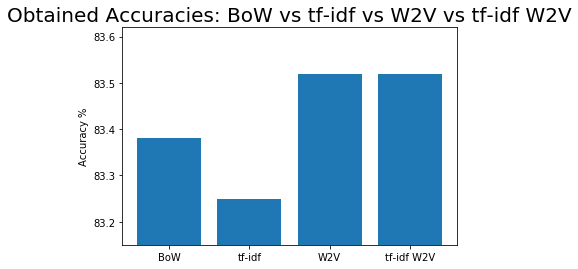

In [63]:
# To plot accuracy percentrage obtatined using 4 Featurizations

data = [83.38,83.25,83.52, 83.52]

x = np.arange(4)
plt.bar(x, height= data)
plt.xticks(x, ['BoW','tf-idf','W2V', 'tf-idf W2V']);
plt.ylim([min(data)-.1, max(data)+.1])

plt.ylabel('Accuracy %')
plt.title('Obtained Accuracies: BoW vs tf-idf vs W2V vs tf-idf W2V', fontsize=20)
plt.show()

## Running Time Analysis: kd-tree vs Brute Force

The comparison of running time between kd-tree and brute force knn for varying dataset sizes is plotted below. The values hardcoded are noted after timing the code run multiple times with varying parameters.

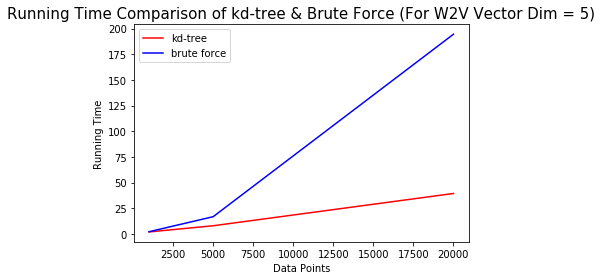

In [44]:
# with w2v dimension = 5

plt.plot([1000,5000,20000], [1.92,7.92,39.35], 'r-', label='kd-tree')
plt.plot([1000,5000,20000], [2.11,16.74,194.46], 'b-', label='brute force')
plt.xlabel('Data Points')
plt.ylabel('Running Time')
plt.title('Running Time Comparison of kd-tree & Brute Force (For W2V Vector Dim = 5)', fontsize=15)
plt.legend()
plt.show()

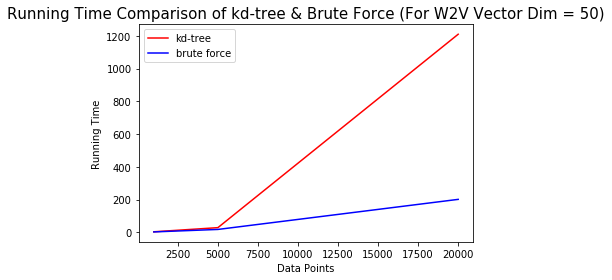

In [45]:
# with w2v dimension = 50

plt.plot([1000,5000,20000], [2.94,28.24,1210.01], 'r-', label='kd-tree')
plt.plot([1000,5000,20000], [2.14,17.29,200.99], 'b-', label='brute force')
plt.xlabel('Data Points')
plt.ylabel('Running Time')
plt.title('Running Time Comparison of kd-tree & Brute Force (For W2V Vector Dim = 50)', fontsize=15)
plt.legend()
plt.show()

## Observations

1. The Accuracy obtained using **W2V featurization is slightly higher** than BoW and tf-IDF methods, though not significantly higher.

2. **When dimension is small (dim=5), the increase in running time of kd-tree knn is linear but the brute force algorithm is exponential. Hence, at lower dimensions, kd-tree performs better.**

3. **When dimension is high (dim=50), the increase in running time of kd-tree knn is exponential, but brute force algorithm is comparatively linear. Hence, brute force is better when dimension is high. **

4. **Explanation of 2 & 3: ** It is known that kD-Trees **don't scale very well with high dimensionality**. When d is not small, the time complexity  of knn becomes, O (2^d*log n). When 2^d = n, then time complexity = O (n log n) which is more than brute force (O (n)). This explains (3).

5. Even when d is small, **time complexity of kd-tree would be O (log n) only when data is uniformly distributed**. When data is not uniform, then kd-tree would move towards complexity of simple implementation, O (n)

6. It has been noticed that the **general rules given in (2) and (3) are not hard and fast**. For the same number of datapoints, kd-tree is seen much efficient at very high dimensions.

    **Timing Results:** <br>
    (W2V dimension = 50) Brute Force = 2.16 seconds; kd-tree = 4.06 seconds<br>
    (W2V dimension = 500) Brute Force = 26.55 seconds; kd-tree = 25.14 seconds.<br><br>
    
    **Reason:** The performance may depend a lot on the characteristics of the data. For example, are the data points evenly distributed, clustered or otherwise arranged?

<br>**Note:**
**What happens for kd-tree at high dimensions?** To evaluate a query point at boundary, the circle drawn would intersect all adjoining regions. Thus, we have to look at all 2^d adjoining regions. when d = 20 then there are 1 million regions, which is huge! Thus, when dimensionality is 10K or 20K, then kd-tree is useless, as shown in the timing results.

